# Setting up the Data Lab

### Introduction

For this lab we'll look at some data to try to predict what makes a good high school in New York City.  Let's get started.

### Load the data

In [3]:
import pandas as pd

df = pd.read_csv('./combined_schools-1.csv', index_col = 0)

At this point we may be able to narrow down the data by looking for those columns that are not of type object.  This will give us columns that are principally numeric, and are suited for a regression problem.

Display the non-object columns below.

> Then scan through the list of columns and see if there are any are good candidates as our target.

In [9]:
non_obj_cols = df.select_dtypes(exclude = 'object').columns
non_obj_cols

# Index(['Enrollment', 'Rigorous Instruction - Percent Positive',
#        'Collaborative Teachers - Percent Positive',
#        'Supportive Environment - Percent Positive',
#        'Effective School Leadership - Percent Positive',
#        'Strong Family-Community Ties - Percent Positive',
#        'Trust - Percent Positive', 'Average Grade 8 English Proficiency',
#        'Average Grade 8 Math Proficiency', 'Percent English Language Learners',
#        'Percent Students with Disabilities', 'Percent Self-Contained',
#        'Economic Need Index', 'Percent Overage/ Undercredited',
#        'Percent in Temp Housing', 'Percent HRA Eligible', 'Percent Asian',
#        'Percent Black', 'Percent Hispanic', 'Percent White',
#        'Years of principal experience at this school',
#        'Percent of teachers with 3 or more years of experience',
#        'Student Attendance Rate', 'Percent of Students Chronically Absent',
#        'Teacher Attendance Rate', 'total_students', 'graduation_rate',
#        'attendance_rate', 'pct_stu_enough_variety', 'college_career_rate',
#        'pct_stu_safe', 'girls', 'boys', 'pbat', 'international', 'specialized',
#        'transfer', 'ptech', 'earlycollege', 'school_accessibility_description',
#        'zip', 'Latitude', 'Longitude', 'Community Board', 'Council District',
#        'Census Tract', 'BIN', 'BBL'],
#       dtype='object')

Index(['Enrollment', 'Rigorous Instruction - Percent Positive',
       'Collaborative Teachers - Percent Positive',
       'Supportive Environment - Percent Positive',
       'Effective School Leadership - Percent Positive',
       'Strong Family-Community Ties - Percent Positive',
       'Trust - Percent Positive', 'Average Grade 8 English Proficiency',
       'Average Grade 8 Math Proficiency', 'Percent English Language Learners',
       'Percent Students with Disabilities', 'Percent Self-Contained',
       'Economic Need Index', 'Percent Overage/ Undercredited',
       'Percent in Temp Housing', 'Percent HRA Eligible', 'Percent Asian',
       'Percent Black', 'Percent Hispanic', 'Percent White',
       'Years of principal experience at this school',
       'Percent of teachers with 3 or more years of experience',
       'Student Attendance Rate', 'Percent of Students Chronically Absent',
       'Teacher Attendance Rate', 'total_students', 'graduation_rate',
       'attendance_rate',

We can see that `college_career_rate` and `graduation_rate` could make for targets.  After all, these are both numbers that a school would like to improve, and our model could help determine what promotes a higher graduation rate or college career rate. 

Let's see if there are any other columns that are not currently of type float or integer, but do have numbers in them.  We can use the `contains_numbers` function in our search.

In [6]:
def contains_numbers(column):
    # matches price or percentage but no date     
    regex_string = (r'^(?!.*www|.*-|.*\/|.*[A-Za-z]|.* ).*\d.*')
    return column.str.contains(regex_string).all()

The `contains_numbers` function works on an individual column, but we want to use it in combination with `apply` to loop through our object columns and then return numeric columns.

In [ ]:
obj_df = df.select_dtypes(include = 'object')

In [22]:
col_contains_nums = obj_df.apply(lambda x: contains_numbers(x))
col_contains_nums[:2]

DBN            False
School Name    False
dtype: bool

Then we can select just those columns that contain numbers.

In [24]:
col_contains_nums[col_contains_nums == True]

Series([], dtype: bool)

Ok, it looks like `graduation_rate` and `college_career_rate` are our candidates.  Let's look at them further.

### Exploring our targets

A large part of working with a large dataset is knowing how to perform operations on multiple columns simultaneously.  Let's practice with our prospective columns.

In [26]:
prospective_cols = ['graduation_rate', 'college_career_rate']

Loop through to find the top value counts of both columns.

In [27]:
prosp_df = df[prospective_cols]

In [31]:
[prosp_df[col].value_counts(normalize = True).iloc[:5] for col in prosp_df.columns]

[0.73    0.049751
 0.93    0.037313
 0.99    0.034826
 0.98    0.034826
 0.74    0.034826
 Name: graduation_rate, dtype: float64,
 0.49    0.028721
 0.53    0.028721
 0.57    0.026110
 0.43    0.026110
 0.42    0.026110
 Name: college_career_rate, dtype: float64]

So we can see that there don't appear to be values like `not available` that indicate a lot of missing values.  Let's see a count of the na values for both columns.

In [35]:
prosp_df.isna().sum()

graduation_rate        13
college_career_rate    32
dtype: int64

In [36]:
prosp_df.shape

(415, 2)

So both columns have a pretty small number of missing values.  There's nothing prohibitive there.  Finally, let's see what histograms of the data look like.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cdd86d0>,
      dtype=object)

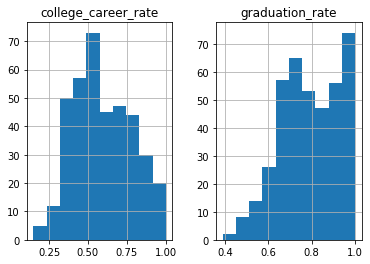

In [37]:
prosp_df.hist()

We can see that there is a broader range of values for `college_career_rate` than for `graduation_rate`.  With graduation rate, most of the values are clustered between `.6` and `1.0`.  Finally we should use describe to also get a sense of the spread of our data.

In [38]:
prosp_df.describe()

,graduation_rate,college_career_rate
count,402.000000,383.000000
mean,0.791169,0.593081
std,0.136092,0.189139
min,0.390000,0.150000
25%,0.690000,0.440000
50%,0.790000,0.570000
75%,0.910000,0.740000
max,1.000000,1.000000


So describe also confirms a mean closer to .5, and a larger interquartile range (the 75th percentile and 25th percentile) of the data.  

One problem with the college_career_rate is that it is measured with the through state exams.  This could allow for scores just being driven by "teaching to the test", and not actually improving school performance or college readiness.  If we tracked `college_career_rate` over time, we would also have to worry about grade inflation.

Let's use both of these as target variables, and see how we do.

### Splitting the Data

Let's check if there are any datetime types that we should look at in splitting the data.

First use `select_dtypes` to select datetime data.

In [41]:
date_df = df.select_dtypes(include = 'datetime64')

date_df.shape

(415, 0)

So there are no datetime columns.  And let's also use the `contains_date` method to loop through the columns and see if there are any dates.

In [42]:
def contains_date(column):
#     remove nas first, potentially use all
    regex_string = (r'^\d{1,2}-\d{1,2}-\d{4}$|^\d{4}-\d{1,2}-\d{1,2}$' + 
'|^\d{1,2}\/\d{1,2}\/\d{4}$|^\d{4}\/\d{1,2}\/\d{1,2}$')
    return column.str.contains(regex_string).any()

In [45]:
cols_contains_date = df.apply(lambda col: contains_date(col))

Then return those values that have a True value for `cols_contains_date`

In [47]:
cols_contains_date[cols_contains_date == True]

# Series([], dtype: bool)

Series([], dtype: bool)

If we take another look through our columns, we'll see if there is no mention of a year or month.

In [57]:
# df.columns

Ok, so it looks like there are no other columns that contain date values either.  So it's ok to split our data randomly.  

In [52]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state = 1, test_size = .2)

And we store our data in separate csv files.

In [53]:
train_df.to_csv('./school_train.csv')

In [54]:
test_df.to_csv('./school_test.csv')

### Summary

In this lesson we went through the process of selecting and exploring a target value, and then splitting our data.  We did so by first looking for numeric columns in our dataset both through the `select_dtypes` method, and by looping through our columns with `contains_numbers`.  

Once we narrowed down some candidates we looked for null values, and the spread of the data to select a target value.  Ultimately, we decided to proceed with both `graduation_rate` and `college_career_rate`.

For splitting the date, we first looked for datetime columns to see if we should split our data by date, but saw there were none in our dateset.